# Church Farm 2023 data 

Run in 24hr_env for now

- Looking at specific pathogens at Genus level (Puccinia, Blumeria, Fusarium, Zymoseptoria, Ustilago, Magnaporthe)
- See how the relative abundance changes over time
- If the pathogens are present consider looking at species level

Initial script was written just using 9 samples from the flush experiment https://docs.google.com/document/d/195KVG5wKhtiVNf4hXisKns8U0gYJ3icAd1u810GMKlc/edit#heading=h.mdjgzo7ffwni 

Before starting I get MARTi lineage data using taxonkit, script is within this directory ([Script](taxonkit_lineage_from_marti.sh)) https://docs.google.com/document/d/1s6LFdmZNQqBXO8JnumuIPyfSVSoHIF86bU2hCJQBiSw/edit

In [9]:
import pandas as pd
from dateutil.parser import parse
import seaborn as sns
import datetime as dt
from matplotlib.dates import HourLocator, DateFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np


## Reading in and prep the data 
- lineage data
- MARTi 
- metadata
- PHIbase taxonomic data (Have not generated for this sequencing run)

Data from the flush experiment - no longer looking at individually

In [2]:
# marti_flush = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/flush_experiment_160124/flush_experiment_marti_lca_0.1_all_levels_2024-FEB-22_10-25-17.csv")
# marti_lineage = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/flush_experiment_160124/flush_experiment_marti_lca_0.1_all_levels_2024-FEB-22_10-25-17_taxaID_lineage.csv")
# marti_lineage = marti_lineage.drop(0) #removing the first row \
# marti_lineage['NCBI ID'] = marti_lineage['NCBI ID'].astype('int64')

Read in and clean taxonkit lineage data

In [4]:
marti_lineage = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/Regular_Collections_2023/marti_assignments_lca_0.0_all_levels_2024-OCT-8_16-34-1_taxaID_lineage.csv")
marti_lineage = marti_lineage.drop(0) #removing the first row \
marti_lineage['NCBI ID'] = marti_lineage['NCBI ID'].astype('int64')


In [8]:
#Check no NCBI IDs are missing in the lineage data
# missing_taxaIDs = marti[~marti['NCBI ID'].isin(marti_lineage['NCBI ID'])]
# missing_taxaIDs # should be empty

Read in and clean MARTi Read counts - 
This has a column for the sumgned (not labelled) and summed read count for all the barcode. I want to use the sumgned counts, as with full lineage I can collapse to different taxonomic levels and sum as necessary. Contig stats and data are from the flush experiment

In [5]:
marti = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/Regular_Collections_2023/marti_assignments_lca_0.0_all_levels_2024-OCT-8_16-34-1.tsv", sep='\t')

#Assigned dataset
columns_to_keep_a = [col for col in marti.columns if 'Summed' not in col and 'identity' not in col]
marti_assi = marti[columns_to_keep_a]

# The string to be removed
string_to_remove_a = " (regular_cf_2023_lm) Read count"
# Modify all column headers to remove the specified string
marti_assi.columns = [col.replace(string_to_remove_a, '') for col in marti_assi.columns]

#Summed dataset
columns_to_keep_s = [col for col in marti.columns if 'Summed' in col or 'Name' in col or 'NCBI' in col]
marti_sum = marti[columns_to_keep_s]
# The string to be removed
string_to_remove_s = " (regular_cf_2023_lm) Summed read count"
# Modify all column headers to remove the specified string
marti_sum.columns = [col.replace(string_to_remove_s, '') for col in marti_sum.columns]

Reading and cleaning the metadata 
- convert date formats 

In [36]:
meta = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/CF_2023_metadata.csv")

# This is assuming where I don't know the date of collection it's on the 14th of the month as that's the middle

def parse_dates(x):
    try:
        # If the date is in 'mm-yy' format, add '14-' to the start to make it 'dd-mmm-yy'
        if '-' in x and len(x) == 6:
            x = '14-' + x

        return parse(x, dayfirst=True)
    except:
        return pd.NaT

meta['Date collected'] = meta['Date collected'].apply(parse_dates)

meta[['DNA extracted?', 'WGA date', 'Initial bead clean up']] = meta[
    ['DNA extracted?', 'WGA date', 'Initial bead clean up']].apply(
        lambda x: pd.to_datetime(x, format='%d/%m/%Y'))

0    2022-10-03
1    2022-10-03
2    2022-11-14
3    2022-11-14
4    2022-12-14
5    2022-12-14
6    2023-01-14
7    2023-01-14
8    2023-02-14
9    2023-02-14
10   2023-03-14
11   2023-03-14
12   2023-04-14
13   2023-04-14
14   2023-05-25
15   2023-05-25
16   2023-06-02
17   2023-06-02
18   2023-06-06
19   2023-06-14
20   2023-06-14
21   2023-06-21
22   2023-06-21
23   2023-06-30
24   2023-06-30
25   2023-07-07
26   2023-07-07
27   2023-07-12
28   2023-07-12
29   2023-07-20
30   2023-07-20
31   2023-07-27
32   2023-07-27
33   2023-08-03
34   2023-08-03
35   2023-08-09
36   2023-08-09
37   2023-08-17
38   2023-08-17
Name: Date collected, dtype: datetime64[ns]

Parsing the contig stats data
- Which has all the barcode info from the sequencing 
- I am only interested in barcode 1 - 39 for this experiment

In [7]:
contig_stats = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/Regular_Collections_2023/combined_contig_stats.tsv", sep='\t')
contig_stats = contig_stats.replace(',', '', regex=True) #Don't need this as there aren't commas
contig_stats['Barcode'] = contig_stats['Barcode'].str.replace('barcode', '')
contig_stats.iloc[:] = contig_stats.iloc[:].astype(int)
contig_stats = contig_stats[contig_stats['Barcode'].astype(int) <= 39]

### Merging all the various datasets together
Working on this section of script, specifically contig stats

In [10]:
# Assigned data!!

#Melt the data to long
marti_assi_long = marti_assi.melt(
    id_vars = ['Name', 'NCBI ID', 'NCBI Rank'],           # the columns we want to keep
    var_name = 'Sample',    # the name of the new column with old column names (to contain the cols we are combining)
    value_name = 'read count' # the name of the new column with old column values
)

#Add lineage data and merge on NCBI ID
marti_lin_merge = marti_assi_long.merge(marti_lineage, how='right')

# #Add metadata and merge on Sample which the same in metadata
marti_lin_meta_merge = marti_lin_merge.merge(meta, how='right')

#Use meta to add sample to contig stats using barcode 
contig_stats['Sample'] = contig_stats['Barcode'].map(meta.set_index('Barcode')['Sample'])

#then merge on Sample
marti_all_data = marti_lin_meta_merge.merge(contig_stats, how='right', on='Sample')

#Create column for relative abundance
marti_all_data["rel_abundance"] = (marti_all_data["read count"] / marti_all_data["NumContigs"]) * 100
marti_all_data["ln_rel_abundance"] = np.log(marti_all_data["rel_abundance"])

#create column for HPM
marti_all_data["HPM"] = (marti_all_data["read count"] / marti_all_data["NumContigs"]) * 1000000
marti_all_data["ln_HPM"] = np.log(marti_all_data["HPM"])

/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
#Summed data!!

#Melt the data to long
marti_sum_long = marti_sum.melt(
    id_vars = ['Name', 'NCBI ID', 'NCBI Rank'],           # the columns we want to keep
    var_name = 'Sample',    # the name of the new column with old column names (to contain the cols we are combining)
    value_name = 'read count' # the name of the new column with old column values
)

#Add lineage data and merge on NCBI ID
marti_lin_merge_sum = marti_sum_long.merge(marti_lineage, how='right')

# #Add metadata and merge on Sample which the same in metadata
marti_lin_meta_merge_sum = marti_lin_merge_sum.merge(meta, how='right')

#Use meta to add sample to contig stats using barcode 
contig_stats['Sample'] = contig_stats['Barcode'].map(meta.set_index('Barcode')['Sample'])

#then merge on Sample
marti_all_data_sum = marti_lin_meta_merge_sum.merge(contig_stats, how='right', on='Sample')

#Create column for relative abundance
marti_all_data_sum["rel_abundance"] = (marti_all_data_sum["read count"] / marti_all_data_sum["NumContigs"]) * 100
marti_all_data_sum["ln_rel_abundance"] = np.log(marti_all_data_sum["rel_abundance"])

#create column for HPM
marti_all_data_sum["HPM"] = (marti_all_data_sum["read count"] / marti_all_data_sum["NumContigs"]) * 1000000
marti_all_data_sum["ln_HPM"] = np.log(marti_all_data_sum["HPM"])

marti_genus_data = marti_all_data_sum[marti_all_data_sum['NCBI Rank'] == 'genus']

/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Reading in PHIbase data and merging

Not doing this for now as I don't have this data from aligning reads to PHIbase yet

In [8]:
# path_data = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/flush_experiment_160124/PHIbase/fl_exp_all_taxaID_count.tsv",  sep='\t' , header=None)
# path_data.columns = ['taxid', 'count', 'barcode']

# #Read in the lineage data for PHIbase and only retain unique rows
# path_lineage = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/flush_experiment_160124/PHIbase/fl_exp_taxaID_lineage_sep_head.csv")
# # Aggregate the lineage dataframe to get unique taxid values
# path_lineage_agg = path_lineage.groupby('taxid').first().reset_index()

# # Merge the aggregated lineage dataframe with the read_count dataframe
# path_lin_merge = pd.merge(path_data, path_lineage_agg, on=['taxid'], how='left')

# #Change barcode to Flush Barcode so I can merge the metadata
# path_lin_merge = path_lin_merge.rename(columns={'barcode': 'Flush_Barcode'})

# #Only going to retain the rows I am interested in
# meta_small = meta[
#     (meta['Flush_Barcode'] > 0)
# ]
# meta_small['Flush_Barcode'] = meta_small['Flush_Barcode'].astype('int64')

# #Merge the metadata
# path_lin_meta_merge = path_lin_merge.merge(meta_small, how='right')

# #Change Number to Sample so I can merge the contig stats
# path_lin_meta_merge = path_lin_meta_merge.rename(columns={'Flush_Barcode': 'Barcode'})

# #Add contig stats and merge on Barcode
# path_all_data = path_lin_meta_merge.merge(contig_stats, how='right', on='Barcode')

# #Create column for relative abundance
# path_all_data["rel_abundance"] = (path_all_data["count"] / path_all_data["Basecalled reads"]) * 100

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_75614/1012270055.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_small['Flush_Barcode'] = meta_small['Flush_Barcode'].astype('int64')


## Now to see what pathogens are present

Firstly in the MARTi data

Plotting a HPM histogram to help me decide the threshold I should filter at.

/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


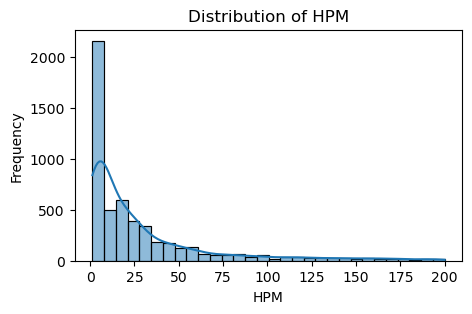

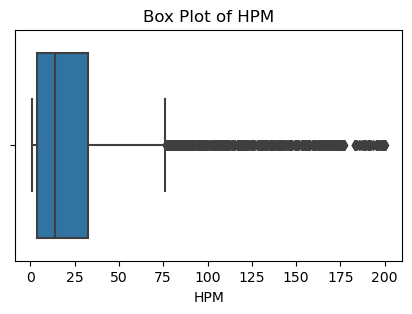

In [12]:
#remove unclassified and high HPM values
marti_refine = marti_genus_data[(marti_genus_data['NCBI Rank'] != 'unclassified') &
                               (marti_genus_data['HPM'] < 200) & #Because otherwise the plots are too skewed
                               (marti_genus_data['HPM'] > 0.1)]


# Plotting the histogram
plt.figure(figsize=(5, 3))
sns.histplot(marti_refine['HPM'], bins=30, kde=True)
plt.title('Distribution of HPM')
plt.xlabel('HPM')
plt.ylabel('Frequency')
plt.show()

# Plotting the box plot
plt.figure(figsize=(5, 3))
sns.boxplot(x=marti_refine['HPM'])
plt.title('Box Plot of HPM')
plt.xlabel('HPM')
plt.show()

In [13]:
pathogen_genera = ["Puccinia", "Blumeria", "Fusarium", "Zymoseptoria", "Ustilago", "Magnaporthe",
                    "Claviceps", "Pyrenophora", "Parastagonospora", "Phaeosphaeria"]

pathogen_data = marti_genus_data[
    marti_genus_data["genus"].isin(pathogen_genera) &
    (marti_genus_data['HPM'] > 5)
    ]

# pathogen_data['genus'].value_counts()

Plotting the pathogenic genera relative abundance in each sample, interesting for me to look at but not publishable like this.

## Graphs

setting up parameters

In [42]:
# Sort the data by 'Date collected' 
pathogen_data = pathogen_data.sort_values(by='Date collected')

# Get the time range of your data
min_time = pathogen_data['Date collected'].min()
max_time = pathogen_data['Date collected'].max()

pathogen_data['Date collected'].unique()


<DatetimeArray>
['2022-10-03 00:00:00', '2022-12-14 00:00:00', '2023-02-14 00:00:00',
 '2023-04-14 00:00:00', '2023-05-25 00:00:00', '2023-06-14 00:00:00',
 '2023-06-21 00:00:00', '2023-06-30 00:00:00', '2023-07-07 00:00:00',
 '2023-07-12 00:00:00', '2023-07-20 00:00:00', '2023-07-27 00:00:00',
 '2023-08-03 00:00:00', '2023-08-09 00:00:00', '2023-08-17 00:00:00']
Length: 15, dtype: datetime64[ns]

All pathogens on one graph

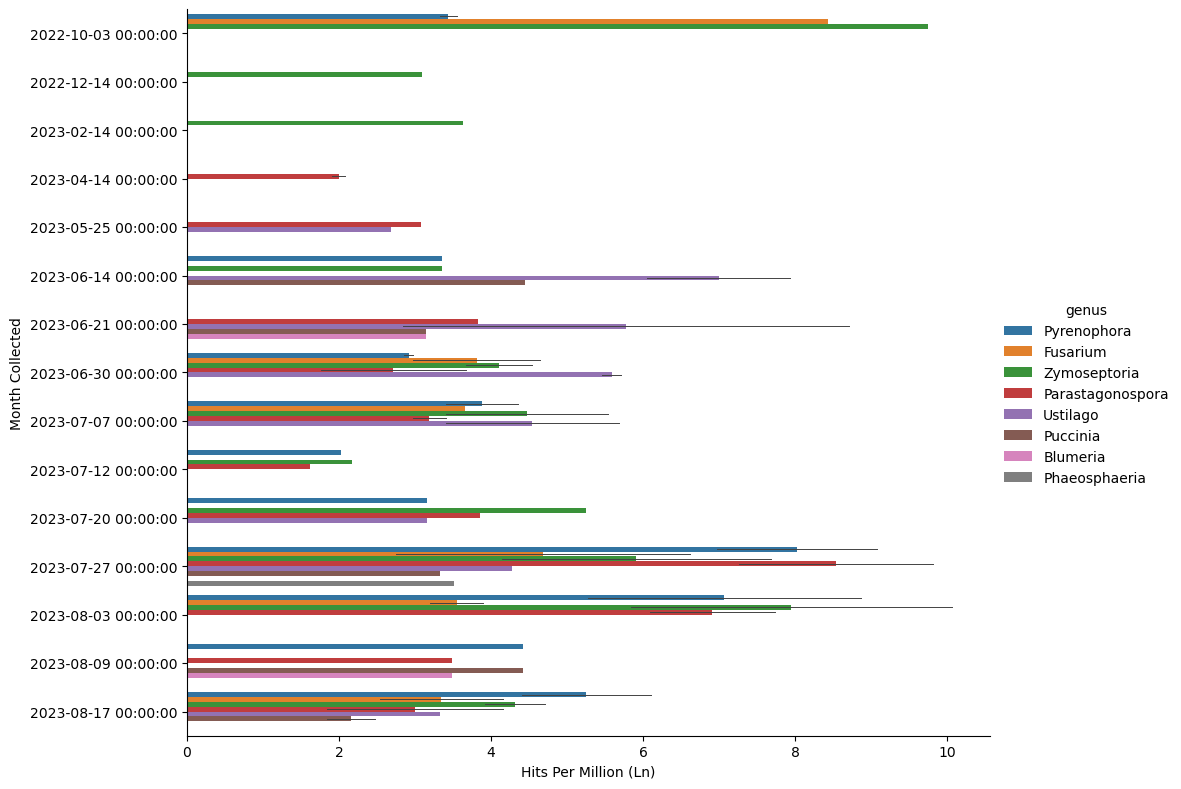

In [44]:
g = sns.catplot(data=pathogen_data,
                y='Date collected', #combines data collected on the same day and plots the average
                x='ln_HPM',
                kind='bar',
                hue='genus',
                dodge=True,
                height=8,  # Increase the height of the plot
                aspect=1.3,  # Increase the aspect ratio of the plot
                errwidth=0.7)  # Increase the width of the errorbars

# Set labels
g.set_axis_labels("Hits Per Million (Ln)", "Month Collected")

# # Set x-axis properties 
# for ax in g.axes.flat:
#     ax.yaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Format x-axis to show months
#     ax.set_ylim([min_time, max_time])      # Set x-axis limits from min_time to max_time

This code has the y axis correct but the data looks wrong

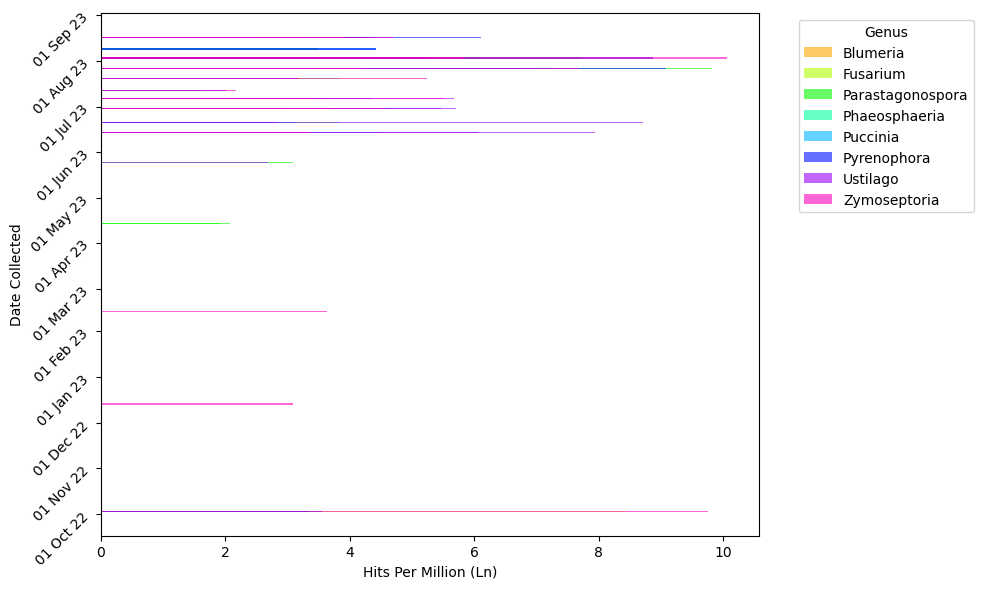

In [198]:
# Ensure 'Date collected' is in datetime format
pathogen_data['Date collected'] = pd.to_datetime(pathogen_data['Date collected'])

# Sort the data by 'Date collected' to ensure proper chronological order
pathogen_data = pathogen_data.sort_values(by='Date collected')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Assign a color palette for different genera
palette = sns.color_palette("hsv", len(pathogen_data['genus'].unique()))

# Create a scatter plot (using bars) for each genus
for (genus, group), color in zip(pathogen_data.groupby('genus'), palette):
    ax.barh(group['Date collected'], group['ln_HPM'], color=color, alpha=0.6, label=genus)

# Format the y-axis to display both day and month (e.g., "03 Oct")
ax.yaxis.set_major_formatter(mdates.DateFormatter('%d %b %y'))

# Set the locator to ensure ticks are spaced at reasonable intervals
ax.yaxis.set_major_locator(mdates.MonthLocator())  # or mdates.WeekdayLocator()

# Set the axis labels
ax.set_xlabel("Hits Per Million (Ln)")
ax.set_ylabel("Date Collected")

# Rotate the y-axis labels for better readability
plt.yticks(rotation=45)

# Add a legend to identify the genera
ax.legend(title='Genus', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()  # Adjust layout for better fit
plt.show()
